# Neuroscience Project

#### Diego Cerretti - Beatrice Citterio - Giovanni De Muri - Mattia Martino - Sandro Mikautadze

This notebook is focused on the exploration and analysis of data concerning neuronal response patterns in the VISam region of the brain, which is critical in the processing of visual stimuli. Utilizing the extensive Allen Brain Observatory dataset provided through the AllenSDK, our objective is to construct a model that is able to capture the dependency of a subset of the neurons' firing rates on the properties of images.

In particular, we will dedicate our analysis on a specific set of images, namely *static gratings*, which are pictures showing black and white grids in various orientations, spatial frequencies and phases. Hence, our research aims at predicting specific neurons' responses as a mouse is shown a static grating image with a particular value for each of those three properties.

### Imports


Let us begin by importing the necessary libraries.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts, raster_plot
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

### Preliminary Analysis

In order to run the following section, we should have a folder './allendata' with the sessions that we are interested in.

In [ ]:
#get the data from the ./allendata folder
data_dir = "./allendata"
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

We will collect data from a specific session of the AllenSDK dataset.

In [ ]:
#get the data from one session
session_id = 798911424 # for simplicity, this is the session we have already downloaded (female mice with nice unit count)
oursession = cache.get_session_data(session_id, timeout=3000)

Let's have a glance at the dataset relative to the neurons' informations

In [ ]:
#Get some info about the neurons
units =  oursession.units
oursession.units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951088679,0.620607,82.147455,0.023654,1,480.97,2.575648,7.429131,0.053350,51.364291,0.028062,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088664,0.587044,78.399165,0.001739,0,427.07,3.085334,6.843864,0.033732,40.358293,0.051513,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088734,0.560996,187.504005,0.001249,5,311.01,5.152564,1.418476,0.356931,56.950961,0.001292,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088721,0.474457,196.741545,0.000059,4,355.17,4.295014,11.517381,0.000271,58.358552,0.020218,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088862,0.534674,92.125020,0.089901,16,239.50,4.043348,19.953126,0.013619,79.934237,0.011335,...,215.0,APN,8304.0,2958.0,7103.0,probeA,See electrode locations,29999.965974,1249.998582,True


It is necessary to filter the good units, that are those that have an high SNR and a low isi violation. They are the units that we want to use in our analysis.

In [ ]:
#Find good units
print(f'{oursession.units.shape[0]} units total')
good_units = oursession.units[(oursession.units.snr > 1) & (oursession.units.isi_violations < 0.5)] #signal to noise ratio. It is the amplitude squared of a signal divided by the variance of the system noise.
print(f'{good_units.shape[0]} units have snr > 1, isi_violations < 0.5')

825 units total
812 units have snr > 1, isi_violations < 0.5


Now, let's take a look at the table relative to the informations on the stimuli shown to the mouse.

In [ ]:
#Get some info on presented stimulus
stimuli = oursession.get_stimulus_table()
oursession.get_stimulus_table().head()

,stimulus_block,start_time,stop_time,temporal_frequency,x_position,contrast,stimulus_name,size,spatial_frequency,color,frame,orientation,y_position,phase,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,24.875987,84.942787,null,null,null,spontaneous,null,null,null,null,null,null,null,60.066800,0
1,0.0,84.942787,85.176306,4.0,20.0,0.8,gabors,"[20.0, 20.0]",0.08,null,null,90.0,-10.0,"[3644.93333333, 3644.93333333]",0.233519,1
2,0.0,85.176306,85.426505,4.0,30.0,0.8,gabors,"[20.0, 20.0]",0.08,null,null,0.0,40.0,"[3644.93333333, 3644.93333333]",0.250199,2
3,0.0,85.426505,85.676704,4.0,40.0,0.8,gabors,"[20.0, 20.0]",0.08,null,null,45.0,-30.0,"[3644.93333333, 3644.93333333]",0.250199,3
4,0.0,85.676704,85.926904,4.0,0.0,0.8,gabors,"[20.0, 20.0]",0.08,null,null,90.0,-40.0,"[3644.93333333, 3644.93333333]",0.250199,4


A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values.

We could also take a look at more general information, such as the different type of stimulus

In [ ]:
#Different types of stimulus
oursession.metadata["stimulus_names"]

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes',
 'drifting_gratings_contrast']

As previously mentioned, our analysis will solely focus on the static_gratings stimulus.

Let's first take a look at the general distribution of the firing rate.

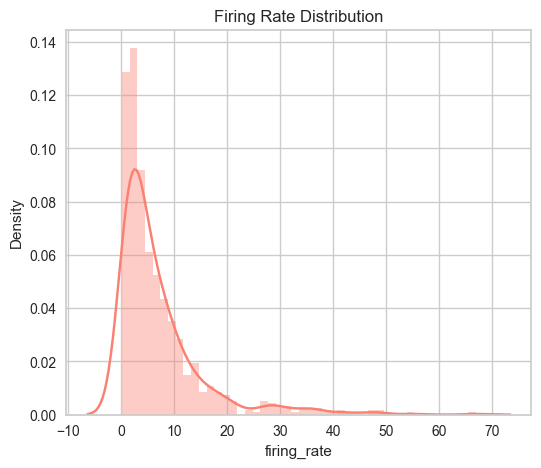

In [ ]:
# distribution of firing rate
fig, ax = plt.subplots(figsize=(6, 5))
sns.distplot(oursession.units['firing_rate'], kde=True, hist=True, ax=ax, color='salmon')
ax.set_title("Firing Rate Distribution")
plt.show()

It looks like neurons have firing rates between 0 and 70 in each trial, let's verify this.

In [ ]:
#Firing rate range
print('Firing rate range: (', oursession.units['firing_rate'].max(), ',', oursession.units['firing_rate'].min(),')')

Firing rate range: ( 66.9073062070194 , 0.0958040655106667 )


For each neuron, let us observe its overall amount of spikes in the experiment.

77545 spikes were detected for unit 951088679 at times:


[]

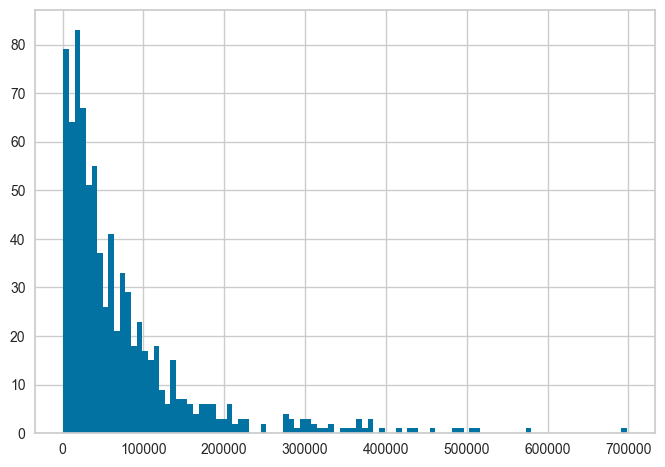

In [ ]:
#Number of total spikes for a single unit
good_units_ids = good_units.index.values
unit_id = good_units_ids[0]
print(f"{len(oursession.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")

total_number_spikes = [len(oursession.spike_times[unit_id]) for unit_id in good_units_ids]
plt.hist(total_number_spikes, bins = 100)
plt.plot()

Splitting our data relative to the brain regions, let us look at how the firing rates statistics compare.

[]

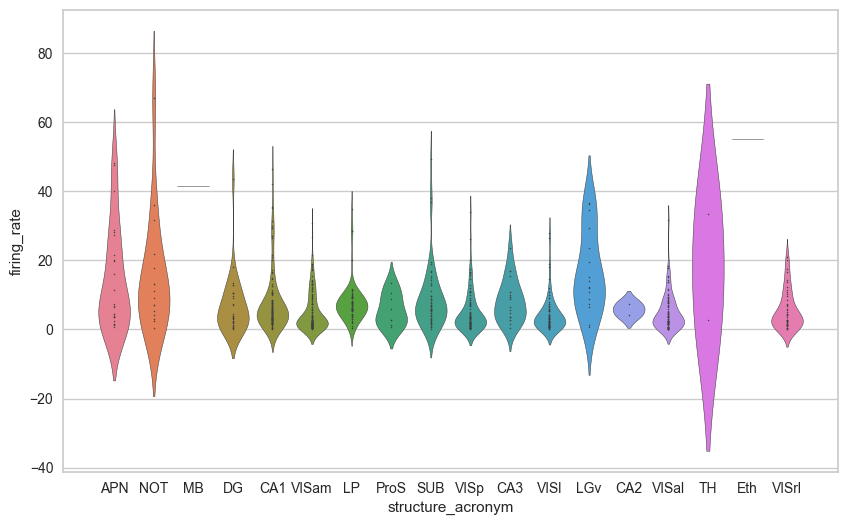

In [ ]:
#plot showing the firing rate in different areas of the brain (structure_acronym is the part of the brain)
plt.figure(figsize=(10, 6))
sns.violinplot(y='firing_rate', x='structure_acronym', data = good_units, hue='structure_acronym', legend = False, inner = 'points')
plt.plot()

This violin plot compares the distribution of firing rates across various brain regions. We can tell that the spike variability is similar across all "violins", as represented by their similar widths. In addition, all regions have similar median values.

The regions Eth, TH, CA2, and MB, seem to be under-represented. We will further analyze this aspect in the next cells.

Let's see the areas from which the neurons in our session are taken from.

In [ ]:
#Number of neuron per area
oursession.units["ecephys_structure_acronym"].value_counts()

VISam    135
CA1      134
VISp      94
VISal     89
VISl      78
LP        65
SUB       59
VISrl     47
DG        31
APN       25
CA3       21
NOT       16
LGv       16
ProS       9
CA2        2
TH         2
MB         1
Eth        1
Name: ecephys_structure_acronym, dtype: int64

As stated, some regions could be ignored due to the very low amount of data they provide on different neurons.

See [link](https://atlas.brain-map.org/atlas?atlas=602630314) for more info on abbreviations of the different regions.

### Static Gratings

As mentioned, we focus on the simplest stimulus, that is static_gratings. Each static_grating is characterized by four properties (orientation, spatial_frequency, phase, duration).

For each property, we observe the possible values it takes. Then, we look at the durations of each trial.

In [ ]:
#Create table with information on static_gratings, see which numerical values they are characterized by.
static_gratings = oursession.get_stimulus_table("static_gratings")

print("STATIC GRATINGS")
print('Possible values:')
print(' - Orientation: ', static_gratings['orientation'].unique())
print(' - Spatial_frequency: ', static_gratings['spatial_frequency'].unique())
print(' - Phase: ', static_gratings['phase'].unique())
print(' - Contrast: ', static_gratings['contrast'].unique())

print('\n Duration statistics: ')
print(static_gratings['duration'].describe())

STATIC GRATINGS
Possible values:
 - Orientation:  [150.0 0.0 30.0 60.0 90.0 120.0 'null']
 - Spatial_frequency:  [0.02 0.16 0.04 0.08 0.32 'null']
 - Phase:  ['0.5' '0.25' '0.75' '0.0' 'null']
 - Contrast:  [0.8 'null']

 Duration statistics: 
count    6000.000000
mean        0.250209
std         0.000005
min         0.250193
25%         0.250206
50%         0.250209
75%         0.250212
max         0.250227
Name: duration, dtype: float64


All durations are pretty much the same. For this reason, we will ignore the property "duration" in the next steps.

When processing visual input, it's important to study the specific regions of the brain that are involved in visual stimuli. Therefore, we exclude the CA1 region of the hippocampal circuit, which is responsible for forming, consolidating, and retrieving hippocampal-dependent memories, as well as the SUB (subiculum) region. You can find more information about this in the following sources: [Bartsch et al., 2011](https://www.pnas.org/doi/full/10.1073/pnas.1110266108#:~:text=Within%20the%20hippocampal%20memory%20system,retrieval%20of%20hippocampal%2Ddependant%20memories) and [Subiculum, Wikipedia](https://en.wikipedia.org/wiki/Subiculum#:~:text=smaller%20cell%20sizes.-,Function,hypothalamic%2Dpituitary%2Dadrenal%20axis).

The VISam, or Anteromedial Visual Area, is a crucial region of the visual system located in the anterior part of the visual cortex. It receives inputs from other visual areas and sends outputs to various cortical and subcortical regions, highlighting its role in integrating visual processing. Its primary functions include integrating different aspects of visual information, such as color, motion, and spatial details, to create a cohesive visual perception. Additionally, it may help understand complex scenes by integrating contextual information from past experiences or other sensory modalities. Moreover, VISam might be involved in directing attention to relevant visual stimuli and recognizing objects and patterns within the visual field.

Given its important role, and the high amount of data we can retrieve from it, we will solely focus on VISam throughout our research.

## Aggregate statistics: Spikes per unit

#### Useful functions

This section gathers all important functions we will use throughout the project. You can skip them for now, as we will handle them later.

In [ ]:
#Function that return dataframe with corresponding stimulus and its characteristic, and responses of neurons from an area
#Create new table containing the stimulus information and the number of spikes per unit given a stimulus.
def spike_trains(stimulus_type, ecephys_area):
    """
    Auxiliary function that returns 2 dataframes, containing aggregate statistics about an area.
    The first output is a dataframe containing the average firing rate of a unit in the "ecephys_area" in response to "stimulus type"
    The second output is a dataframe containing the spiking times for each unit in "ecephys_area" and each "stimulus_type" presentation.

    Args:
        stimulus_type (string): Tag of the stimulus type
        ecephys_area (string): Tag of the ecephys area
    """
    stim_table = oursession.get_stimulus_table(stimulus_type)

    area_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == ecephys_area].index.values
    stim_ids = stim_table.index.values

    #Create table with spike times of neurons in brain area after static_gratings stimulus
    area_stim_table_spk = oursession.presentationwise_spike_times(
        stimulus_presentation_ids = stim_ids,
        unit_ids = area_ids
    )

    stim_table_spk_count  = area_stim_table_spk.groupby('stimulus_presentation_id').count().reset_index()
    stim_spk_map = dict(zip(stim_table_spk_count['stimulus_presentation_id'], stim_table_spk_count['unit_id']))

    stim_table_spk = oursession.get_stimulus_table(stimulus_type).reset_index()

    #add column with number of spikes
    stim_table_spk['num_spikes'] = stim_table_spk['stimulus_presentation_id'].map(stim_spk_map)

    #total number of units spiking for each stimulus
    spk_units_per_stim = []
    for stim_id in stim_table_spk['stimulus_presentation_id']:
        num_spk_unit = len(area_stim_table_spk[area_stim_table_spk['stimulus_presentation_id'] == stim_id]['unit_id'].unique())
        spk_units_per_stim.append(num_spk_unit)
    stim_table_spk['spiking_units'] = spk_units_per_stim

    #computing spikes per unit
    stim_table_spk['spikes_per_unit'] = stim_table_spk['num_spikes']/(stim_table_spk['spiking_units'])

    # clean df
    if stimulus_type == "static_gratings":
        # drop useless columns
        stim_table_spk = stim_table_spk.drop(columns = ['start_time', 'stop_time', 'contrast', 'size', 'stimulus_name', 'duration', 'stimulus_block'])
        # remove rows with null value
        stim_table_spk = stim_table_spk[~(stim_table_spk == 'null').any(1)]
        #change type of phase columns
        stim_table_spk['phase'] = stim_table_spk['phase'].astype(float)

    return stim_table_spk, area_stim_table_spk

In [ ]:
def plot_two_params(df):
    """
    Auxiliary function for plotting change with 2 parameters at a time

    Args:
        df (pandas.core.frame.DataFrame): Dataframe from which you want to plot
    """
    unique_orientation = sorted(df.orientation.unique())
    unique_phase = sorted(df.phase.unique())
    unique_freq = sorted(df.spatial_frequency.unique())

    fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True)

    for i in unique_orientation:
        for j in unique_phase:
            spk_frequency = df[(df['orientation'] == i) & (df['phase'] == j)]
            ax[0].plot(spk_frequency.groupby('spatial_frequency').mean()['spikes_per_unit'])
    ax[0].set_xlabel("Frequency")

    for i in unique_freq:
        for j in unique_phase:
            spk_orientation = df[(df['spatial_frequency'] == i) & (df['phase'] == j)]
            ax[1].plot(spk_orientation.groupby('orientation').mean()['spikes_per_unit'])
    ax[1].set_xlabel("Orientation")

    for i in unique_freq:
        for j in unique_orientation:
            spk_phase = df[(df['spatial_frequency'] == i) & (df['orientation'] == j)]
            ax[2].plot(spk_phase.groupby('phase').mean()['spikes_per_unit'])
    ax[2].set_xlabel("Phase")

    plt.show()

In [ ]:
def area_presentation_stimulus(stimulus, area):
    """
    Auxiliary function that returns a dataframe, with a MultiIndex.
    The dataframe contains the firing rate and the informations of a unit in "ecephys_area" in response to a "stimulus_type"

    Args:
        stimulus_type (string): Tag of the stimulus type
        ecephys_area (string): Tag of the ecephys area
    """

    area_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == area].index.values

    stim_table = oursession.get_stimulus_table(stimulus)
    stim_ids = stim_table.index.values

    unit_static_grating = oursession.conditionwise_spike_statistics(
        stimulus_presentation_ids = stim_ids,
        unit_ids = area_ids
    )

    unit_static_grating = pd.merge(unit_static_grating, oursession.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)  #merge 2 df
    unit_static_grating = unit_static_grating.drop(columns = ['x_position', 'y_position', 'frame', 'color', 'temporal_frequency'])  #remove null columns
    unit_static_grating = unit_static_grating[~(unit_static_grating == 'null').any(1)]  #remove nulls

    return unit_static_grating

area_static_grating = area_presentation_stimulus('static_gratings', "VISam")

In [ ]:
def get_highest_variance(area, stimulus, percentile):
    """
    Calculate the highest variance of spike counts for a given area and stimulus.

    Parameters:
    area (str): The acronym of the brain area to analyze.
    stimulus (str): The name of the stimulus to analyze.
    percentile (float): The percentile value to use for determining the upper quartile.

    Returns:
    std_spike_count (pandas.Series): The standard deviation of spike counts for each unit.
    highest_variance (pandas.DataFrame): The subset of statistics with the highest variance.

    """
    stim_table = oursession.get_stimulus_table(stimulus)
    stim_ids = stim_table.index.values
    area_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == area].index.values

    stats = oursession.conditionwise_spike_statistics(
        stimulus_presentation_ids=stim_ids,
        unit_ids=area_ids
    )

    stats = pd.merge(stats, oursession.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

    std_spike_count = stats.groupby('unit_id').std()['spike_count']

    if 'unit_id' not in stats.columns:
        stats.reset_index(inplace=True)

    upper_quartile = np.percentile(std_spike_count.sort_values(ascending=False), percentile)
    highest_variance = stats[stats['unit_id'].isin(std_spike_count[std_spike_count > upper_quartile].index)]

    return std_spike_count, highest_variance

In [ ]:
def sort_by_range(stimulus, area):
    ''' Receives stimulus and area, returns spike counts sorted by largest range, and the units sorted by largest range. '''

    df = area_presentation_stimulus(stimulus, area)

    units = df.index.levels[0].to_list()
    spike_range = {}

    for u in units:
        spike_range[u] = df[df.index.isin([u], level=0)].reset_index(level=0, drop=True)['spike_count'].max() - df[df.index.isin([u], level=0)].reset_index(level=0, drop=True)['spike_count'].min()

    spike_range = pd.DataFrame.from_dict(spike_range, orient='index', columns = ['spike_range'])

    reset_df = df.reset_index()
    merged_df = pd.merge(reset_df, spike_range, left_on='unit_id', right_index=True, how='left')
    merged_df.set_index(df.index.names, inplace=True)
    col = merged_df.pop('spike_range')
    merged_df.insert(0, 'spike_range', col)
    sorted_df = merged_df.sort_values(by='spike_range', ascending=False)

    sorted_units = sorted_df.index.levels[0].to_list()

    spike_range = spike_range.sort_values(by = 'spike_range', ascending=False)

    return sorted_df, sorted_units, spike_range


In [ ]:
def check_modulation_line(df):
    ''' Receives df, returns n neurons with the highest modulation.
    The modulation metric in this case is the error when fitting an horizontal line to the data (equal to the mean)
    '''
    h_line = df.groupby('unit_id')['spike_count'].mean()
    h_line = (h_line - np.mean(df['spike_count']))/np.std(df['spike_count'])

    errors = {}
    for unit in df['unit_id'].unique():
        error = 0
        df_filtered = df[df['unit_id'] == unit]
        for y in df_filtered['spike_count']:
            y = (y - np.mean(df['spike_count']))/np.std(df['spike_count'])
            error = error + (y-h_line[unit])**2

        errors[unit] = error / df_filtered.shape[0]

    highest_keys = sorted(errors, key=errors.get, reverse=True)
    return highest_keys

In [ ]:
def check_modulation_line_useless(stimulus, area):
    ''' Receives df, returns n neurons with the highest modulation.
    The modulation metric in this case is the error when fitting an horizontal line to the data (equal to the mean)
    '''
    df = area_presentation_stimulus(stimulus, area)

    h_line = df.groupby('unit_id')['spike_count'].mean()
    h_line = (h_line - np.mean(df['spike_count']))/np.std(df['spike_count'])

    errors = {}
    for unit in list({i[0] for i in df.index}):
        error = 0
        df_filtered = df[df.index.get_level_values(0) == unit]
        for y in df_filtered['spike_count']:
            y = (y - np.mean(df['spike_count']))/np.std(df['spike_count'])
            error = error + (y-h_line[unit])**2

        errors[unit] = error / df_filtered.shape[0]

    highest_keys = sorted(errors, key=errors.get, reverse=True)
    return highest_keys


In [ ]:
def spike_count_by_param(stimulus, area, var_names, measure, percentile):

    if measure == "var":
        _ , df = get_highest_variance(area, stimulus, percentile)

        num_var = len(var_names)
        num_cols = 3
        num_rows = (num_var + num_cols - 1) // num_cols

        # Create figure and axes
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

        # Flatten the axs array if it's more than 1 row
        if num_rows > 1:
            axs = axs.flatten()

        # Plot each element in a separate subplot
        count = 0
        for var_name in var_names:
            df[var_name] = pd.to_numeric(df[var_name], errors='coerce')
            df_var = df.dropna(subset=[var_name])

            ax = axs[count]
            ax.plot(df_var[var_name], df_var['spike_count'], marker='o', linestyle='-', color='blue', markersize=4, alpha=0.15)
            ax.set_title('Spike counts by ' + var_name)
            ax.set_xlabel(var_name)
            ax.set_ylabel('Spike counts')
            ax.grid(True)

            count = count + 1

        # Hide any empty subplots
        for i in range(num_var, num_rows * num_cols):
            fig.delaxes(axs[i])

        plt.tight_layout()
        plt.show()

    if measure == "range":
        sorted_df, sorted_units, _ = sort_by_range(stimulus, area)
        num_units_to_take = int(len(sorted_units) * ((100-percentile)/100))
        top_10_percent_units = sorted_units[:num_units_to_take]
        df = sorted_df.loc[top_10_percent_units]


        num_var = len(var_names)
        num_cols = 3
        num_rows = (num_var + num_cols - 1) // num_cols

        # Create figure and axes
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

        # Flatten the axs array if it's more than 1 row
        if num_rows > 1:
            axs = axs.flatten()

        # Plot each element in a separate subplot
        count = 0
        for var_name in var_names:
            df[var_name] = pd.to_numeric(df[var_name], errors='coerce')
            df_var = df.dropna(subset=[var_name])

            ax = axs[count]
            ax.plot(df_var[var_name], df_var['spike_count'], marker='o', linestyle='-', color='blue', markersize=4, alpha=0.15)
            ax.set_title('Spike counts by ' + var_name)
            ax.set_xlabel(var_name)
            ax.set_ylabel('Spike counts')
            ax.grid(True)

            count = count + 1

        # Hide any empty subplots
        for i in range(num_var, num_rows * num_cols):
            fig.delaxes(axs[i])

        plt.tight_layout()
        plt.show()


In [ ]:
def plot_by_measure(stimulus, area, measure, percentile):
    if measure == "var":
        ''' return a plot of the units sorted by the variance vs the variance'''

        std_spike_count, highest_variance = get_highest_variance(area, stimulus, percentile)

        upper_quartile = np.percentile(std_spike_count.sort_values(ascending=False), percentile)

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(std_spike_count.sort_values(ascending=False))), std_spike_count.sort_values(ascending=False).values, marker='o', linestyle='-', color='blue')
        plt.title('Standard Deviation of Spike Counts by Sorted Unit ID')
        plt.xlabel('Unit ID Index (sorted by Standard Deviation)')
        plt.ylabel('Standard Deviation of Spike Counts')
        plt.grid(True)
        plt.xticks([])  # Remove x-axis labels
        # Add a horizontal line for the upper percentile
        plt.axhline(y=upper_quartile, color='red', linestyle='dotted', label=f'Upper Percentile ({upper_quartile:.2f})')
        plt.legend()
        plt.show()


    if measure == "range":

        ''' return a plot of the units sorted by the spike range vs the spike range'''

        df = area_presentation_stimulus(stimulus, area)
        sorted_df, sorted_units, spike_range = sort_by_range(stimulus, area)
        upper_quartile = np.percentile(spike_range, 80)

        plt.figure(figsize=(10, 6))

        plt.plot(range(len(spike_range)), spike_range.values, marker='o', linestyle='-', color='blue')
        plt.title('Spike range by Sorted Unit ID')
        plt.xlabel('Unit ID Index (sorted by spike range)')
        plt.ylabel('Spike range')
        plt.grid(True)
        plt.xticks([])

        plt.axhline(y=upper_quartile, color='red', linestyle='dotted', label=f'Upper Percentile ({upper_quartile:.2f})')

        plt.legend()
        plt.show()



In [ ]:
def unit_presentation_stimulus(stimulus_type, unit_id):
    """
    Auxiliary function that returns a dataframe, with a single index
    The dataframe contains the firing rate and the informations of the unit "unit_id" in response to a "stimulus_type"

    Args:
        stimulus_type (string): Tag of the stimulus type
        unit_id (string): Tag of the ecephys area
    """

    stim_table = oursession.get_stimulus_table(stimulus_type)
    stim_ids = stim_table.index.values

    unit_static_grating = oursession.conditionwise_spike_statistics(
        stimulus_presentation_ids = stim_ids,
        unit_ids = unit_id
    )

    unit_static_grating = pd.merge(unit_static_grating, oursession.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)  #merge 2 df
    unit_static_grating = unit_static_grating.drop(columns = ['x_position', 'y_position', 'frame', 'color', 'temporal_frequency'])  #remove null columns
    unit_static_grating = unit_static_grating[~(unit_static_grating == 'null').any(1)]  #remove nulls
    unit_static_grating = unit_static_grating.reset_index(level=0, drop=True)   #remove multiindex

    return unit_static_grating

In [ ]:
def important_df(stimulus, area, measure, percentile, n = 5):

    # Return datasets with the highest percentile of neurons by variance and range with respect to trials

    if measure == "var":
        df = get_highest_variance(area, stimulus, percentile)[1]
        df = df[df['unit_id'].isin(check_modulation_line(df)[:n])]
        return df
    if measure  == "range":
            stim_table = oursession.get_stimulus_table(stimulus)
            stim_ids = stim_table.index.values
            area_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == area].index.values

            stats = oursession.conditionwise_spike_statistics(
                stimulus_presentation_ids = stim_ids,
                unit_ids = area_ids
            )


            stats = pd.merge(stats, oursession.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)
            stats = stats.reset_index()
            stats['unit_id'] = pd.Categorical(stats['unit_id'], categories=sort_by_range("static_gratings", "VISam")[1], ordered=True)
            stats = stats.sort_values('unit_id')

            num_rows = len(stats)
            first_10_percent = int(((100-percentile)/100) * num_rows)

            # Select the first 10%
            stats = stats.iloc[:first_10_percent]
            stats.sort_index(inplace=True)

            stats = stats[stats['unit_id'].isin(check_modulation_line(stats)[:n])]

            return stats

In [ ]:
def clean_df(stimulus, area, measure, percentile, save = True):
    df = important_df(stimulus, area, measure, percentile)
    clean = df[['unit_id', 'spike_count', 'orientation', 'phase', 'spatial_frequency']]
    if not save:
        return clean
    clean.to_csv(f"{stimulus}_{area}_{measure}_{percentile}.csv", index=False)

In [ ]:
def clustering_df_init(stimulus, area, params=['spatial_frequency', 'orientation', 'phase']):
    """
    Initialize a DataFrame for clustering analysis.

    Parameters:
    - stimulus (str): The name of the stimulus.
    - area (str): The acronym of the brain area.
    - params (list): The list of parameters to include in the DataFrame. Default is ['spatial_frequency', 'orientation', 'phase'].

    Returns:
    - clustering_df (DataFrame): The initialized DataFrame for clustering analysis.
    """
    stim_table = oursession.get_stimulus_table(stimulus)
    stim_ids = stim_table.index.values
    area_ids = oursession.units[oursession.units["ecephys_structure_acronym"] == area].index.values

    stats = oursession.conditionwise_spike_statistics(
        stimulus_presentation_ids=stim_ids,
        unit_ids=area_ids
        )
    stats = pd.merge(stats, oursession.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

    clustering_df = stats[['spatial_frequency', 'orientation', 'phase']]
    clustering_df = clustering_df.replace('null', np.nan)
    clustering_df = clustering_df.dropna(how='any')
    clustering_df = clustering_df.astype(float)

    return clustering_df

In [ ]:
def k_elbow(stimulus, area, k_range:tuple=(1,6)):
    """
    Finds the optimal number of clusters using the elbow method.

    Parameters:
    - stimulus: The stimulus data.
    - area: The area data.
    - k_range: A tuple specifying the range of k values to consider (default: (1, 6)).

    Returns:
    - The optimal number of clusters determined by the elbow method.
    """

    clustering_df = clustering_df_init(stimulus, area)

    visualizer = KElbowVisualizer(KMeans(), k=k_range, timings= True, random_state=42)
    visualizer.fit(clustering_df)
    return visualizer.elbow_value_

In [ ]:
def k_means_visualizer(stimulus, area, dimensions:int, k_opt):
    """
    Visualizes the results of K-means clustering on the given stimulus and area data.

    Parameters:
    - stimulus: The stimulus data.
    - area: The area data.
    - dimensions: The number of dimensions for visualization (2 or 3).
    - k_opt: The number of clusters to use in K-means clustering.

    Raises:
    - ValueError: If the number of dimensions is not 2 or 3.

    Returns:
    - None
    """

    clustering_df = clustering_df_init(stimulus, area)
    kmeans = KMeans(n_clusters=k_opt, random_state=42, init='k-means++')
    kmeans.fit(clustering_df)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    if dimensions==2:
        pca = PCA(n_components=2)

        PCA_components = pca.fit_transform(clustering_df)
        kmeans.fit(PCA_components)
        cluster_labels = kmeans.predict(PCA_components)

        centroids = kmeans.cluster_centers_
        clustering_df['cluster'] = cluster_labels
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = sns.color_palette("Paired", n_colors=4)

        for i in range(k_opt):
            ax.scatter(PCA_components[clustering_df['cluster']==i, 0], PCA_components[clustering_df['cluster']==i, 1], alpha=0.8, label='Cluster '+str(i+1), color=colors[i])

        ax.scatter(centroids[:,0], centroids[:,1], marker='x', s=30, color='black', alpha = 0.8, label='Centroids')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        ax.legend()
        plt.show()

    elif dimensions==3:
        components = clustering_df.values
        kmeans.fit(components)
        cluster_labels = kmeans.predict(components)
        clustering_df['cluster'] = cluster_labels

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = sns.color_palette("Paired", n_colors=5)

        for i in range(2):
            ax.scatter(components[clustering_df['cluster']==i, 0], components[clustering_df['cluster']==i, 1], components[clustering_df['cluster']==i, 2], alpha=0.8, label='Cluster '+str(i+1), color=colors[i])

        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
                kmeans.cluster_centers_[:,2], s = 30, c = 'black',
                marker='x', label = 'Centroids')
        ax.legend()
        ax.view_init(azim=30, elev=30)

        plt.xlabel('Spatial Frequency')
        plt.ylabel('Orientation')
        ax.set_zlabel('Phase')
        plt.show()

    else:
        raise('ValueError: Number of dimension not implemented')

## VISam

Finally, let's look at the data we have relative to the VISam region.

### EDA

VISam is a very small compared to other areas of the brain, yet it's the one with the most measurements in AllenSDK.

Using a function we previously defined, let's take a clean dataset representing the neuronal activity in the VISam region in response to static_gratings stimuli.

In [ ]:
#show table
static_gratings_spk, visam_grat_spk = spike_trains('static_gratings', 'VISam')
static_gratings_spk.head()

,stimulus_presentation_id,spatial_frequency,orientation,phase,stimulus_condition_id,num_spikes,spiking_units,spikes_per_unit
0,49434,0.02,150.0,0.50,4787,267,69,3.869565
1,49435,0.16,0.0,0.50,4788,381,74,5.148649
2,49436,0.04,30.0,0.25,4789,324,75,4.320000
3,49437,0.04,60.0,0.75,4790,249,69,3.608696
4,49438,0.08,60.0,0.00,4791,237,68,3.485294


In [ ]:
visam_grat_spk.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5399.368409,49434,951092075,0.000562
5399.369989,49434,951097547,0.002142
5399.372375,49434,951093048,0.004529
5399.374142,49434,951092369,0.006295
5399.374475,49434,951093595,0.006629


Let's look at some statistics of the distribution of the spikes per unit.

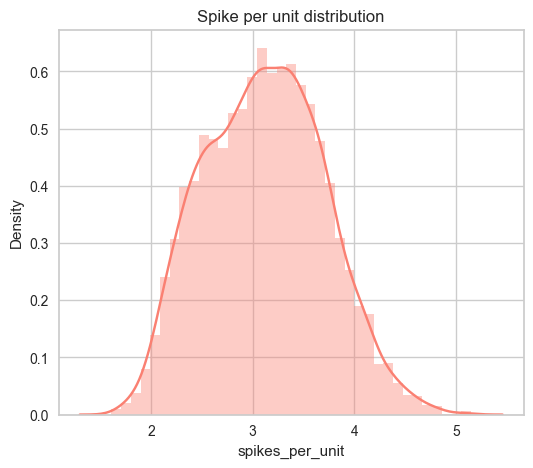

In [ ]:
# Distribution of spikes per unit
fig, ax = plt.subplots(figsize=(6, 5))
sns.distplot(static_gratings_spk['spikes_per_unit'], kde=True, hist=True, ax=ax, color='salmon')
ax.set_title("Spike per unit distribution")
plt.show()

The unit spikes follow an approximate Gaussin distribution, with mean $\sim 3$.

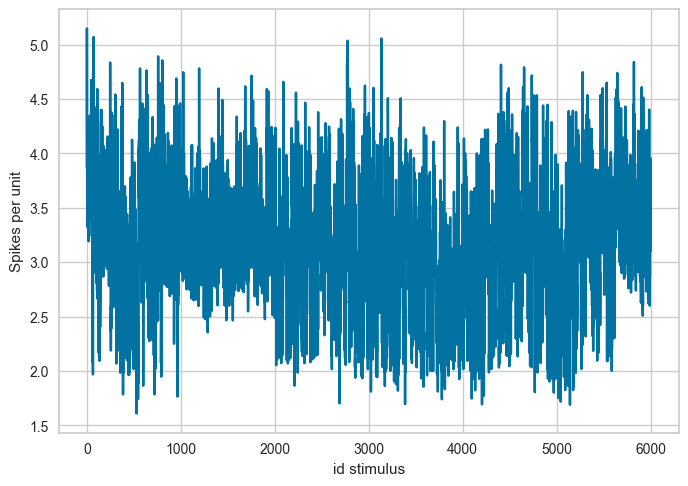

In [ ]:
#Other plot on spikes per unit
plt.plot(static_gratings_spk['spikes_per_unit'])
plt.ylabel('Spikes per unit')
plt.xlabel('id stimulus')
plt.show()

Now we are interested if we can find some variability in the data. First of all how many possible combinations of static gratings we have at our disposal?

In [ ]:
#Number of different static gratings parameters combinations
len(static_gratings_spk['stimulus_condition_id'].unique())

120

Let's see what's the behavior of the spikes per unit if we fix one variable (eg. orientation, spatial frequency).

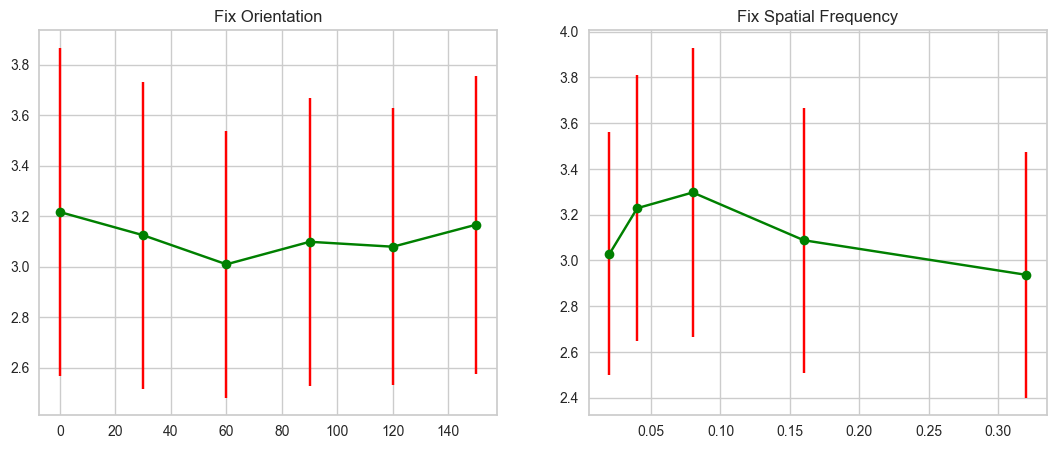

In [ ]:
#Errorbar plot if we fix orientation
fig, ax = plt.subplots(1, 2, figsize=(13,5))

spike_rate_or = static_gratings_spk.groupby('orientation').agg(['mean', 'std'])['spikes_per_unit']
ax[0].errorbar(spike_rate_or.index, spike_rate_or['mean'], yerr = spike_rate_or['std'], fmt = '-o', color = 'green', ecolor = 'red')
ax[0].set_title("Fix Orientation")

spike_rate_sf = static_gratings_spk.groupby('spatial_frequency').agg(['mean', 'std'])['spikes_per_unit']
ax[1].errorbar(spike_rate_sf.index, spike_rate_sf['mean'], yerr = spike_rate_sf['std'], fmt = '-o', color = 'green', ecolor = 'red')
ax[1].set_title("Fix Spatial Frequency")

plt.show()

Naively, we could already hypothesize some trends in the data, but we will this to the next sections in the project.

Now, let's set some values for spatial frequency and phase and see how spikes per unit changes. Notice that more or less, as orientation changes, all units seem to follow the same trend.

[]

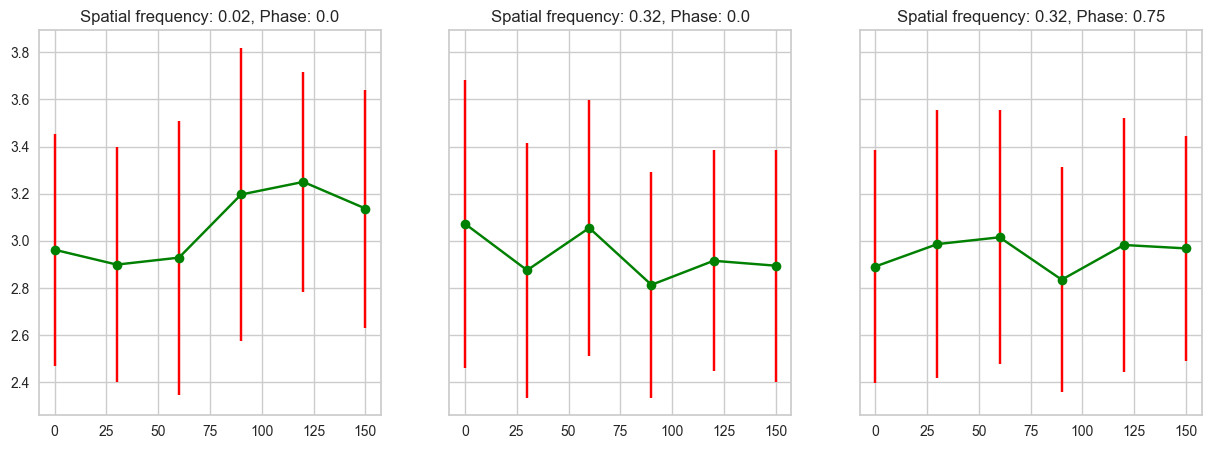

In [ ]:
#Plotted spike per unit as function of orientation, fixing spatial frequency and phase
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
plotted_freq_phase = [(0.02,0.0), (0.32, 0.0), (0.32,0.75)]

num_axis = 0
for i,j in plotted_freq_phase:
    spk_freq_phase = static_gratings_spk[(static_gratings_spk['spatial_frequency'] == i) & (static_gratings_spk['phase'] == j)]
    spk_freq_phase_df = spk_freq_phase.groupby('orientation').agg(['mean', 'std'])['spikes_per_unit']
    ax[num_axis].errorbar(spk_freq_phase_df.index, spk_freq_phase_df['mean'], yerr = spk_freq_phase_df['std'], fmt = '-o', color = 'green', ecolor = 'red')
    ax[num_axis].set_title("Spatial frequency: " + str(i) + ", Phase: " + str(j))
    num_axis = num_axis + 1

plt.plot()

In the first plot there is almost a sudden transition when we reach orientation 90. The second and third plot seem pretty constant, with some deviations.

[]

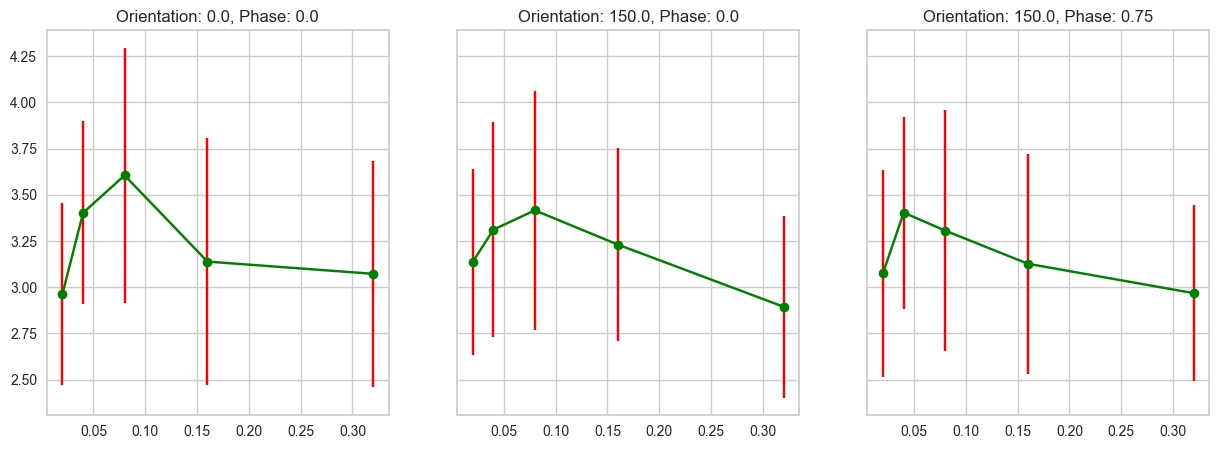

In [ ]:
#Plotted spike per unit as function of frequency, fixing orientation and phase
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
plotted_or_phase = [(0.0,0.0), (150.0, 0.0), (150.0,0.75)]

num_axis = 0
for i,j in plotted_or_phase:
    spk_or_phase= static_gratings_spk[(static_gratings_spk['orientation'] == i) & (static_gratings_spk['phase'] == j)]
    spk_or_phase_df = spk_or_phase.groupby('spatial_frequency').agg(['mean', 'std'])['spikes_per_unit']
    ax[num_axis].errorbar(spk_or_phase_df.index, spk_or_phase_df['mean'], yerr = spk_or_phase_df['std'], fmt = '-o', color = 'green', ecolor = 'red')
    ax[num_axis].set_title("Orientation: " + str(i) + ", Phase: " + str(j))
    num_axis = num_axis + 1

plt.plot()

All plots display a similar behaviour in which a low frequency is correlated to a high firing rate and high frequency with lower firing rate.

Now let's change 2 parameters at a time, and see how the spike per unit changes.

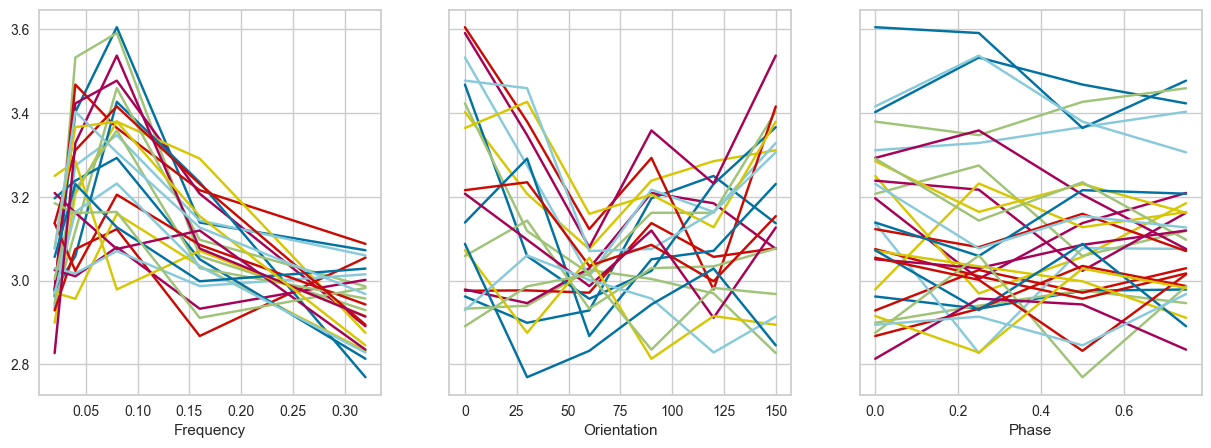

In [ ]:
plot_two_params(static_gratings_spk)

For frequency we see the previous behavior (almost seems like a Gamma distribution). Thus, there seems to be some sort of modulation that affects all neurons. Instead, orientation and phase don't seem to have an important effect on our data.

### Highest Variance

We are now interested in looking for the neurons whose activity has the highest variance. This will be our first attempt to look for those neurons that pass on the highest amount of information relative to some image property.

Using a pre-defined function, let us build a dataset composed of the top $10\%$  neurons by spike variance through trials.

In [ ]:
std_spike_count, highest_variance = get_highest_variance("VISam", "static_gratings", 90)

Let us look at the upper precentile of this distribution, in order to filter only those neurons that have the highest variance.

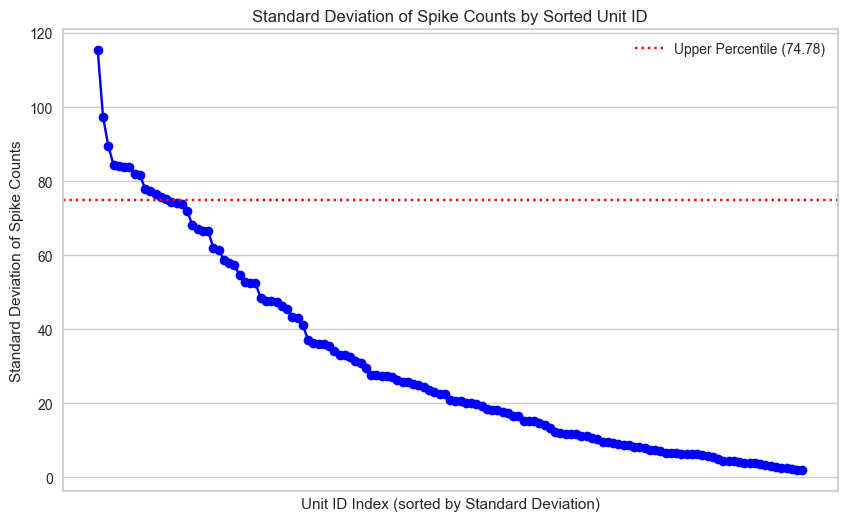

In [ ]:
plot_by_measure("static_gratings", "VISam", "var", 90)

Interestingly, we cannot identify a bulk of neurons having a larger variance compared to the others. Indeed, this curve seems to be pretty continuous. For this reason, we will only study the top $10\%$ as a rule of thumb.

As stated, the properties we are most interested in are: spatial_frequency, orientation, phase

In [ ]:
highest_variance.head()

,unit_id,stimulus_condition_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,temporal_frequency,opacity,x_position,...,mask,stimulus_name,size,spatial_frequency,color,frame,orientation,y_position,phase,color_triplet
6,951092437,4787,155,47,3.297872,3.393824,0.495040,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
17,951092798,4787,52,47,1.106383,1.127406,0.164449,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
21,951092940,4787,282,47,6.000000,2.934058,0.427976,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
22,951092949,4787,297,47,6.319149,1.842805,0.268801,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
24,951092973,4787,270,47,5.744681,2.480078,0.361757,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"


So, those neurons that vary the most are the following:

In [ ]:
print(highest_variance['unit_id'].unique())

[951092437 951092798 951092940 951092949 951092973 951093080 951093125
 951093283 951093608 951093928 951094081 951097547 951098242 951099306]


$14$ neurons compose the top 10 percent of neurons in the VISam area by spike variability.

Let us now look at the statistics of these neurons, as we vary the properties of our image. In particular, let's see if we can notice some trends in the neurons' activities as we vary the values of the three properties shown to the animal.

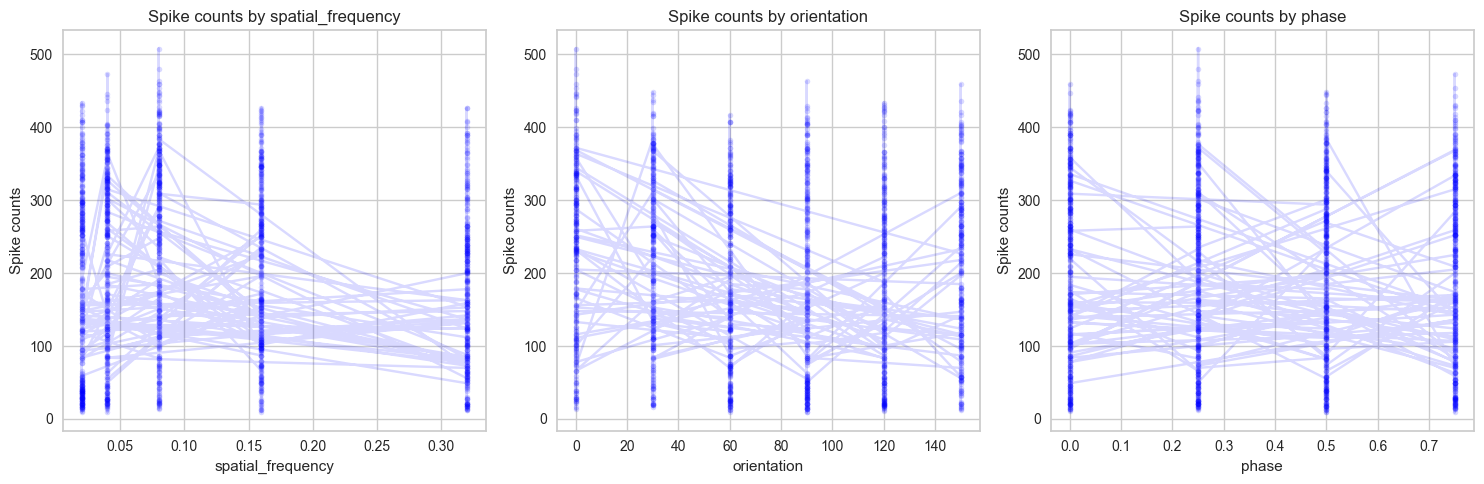

In [ ]:
spike_count_by_param("static_gratings", "VISam", ['spatial_frequency', 'orientation', 'phase'], "var", 90)

From these graphs it is hard to tell whether specific values of these properties determine a change in activity of the neurons. One of the reasons for this is that often neurons are only shown one particular value of the property, and therefore it is impossible for us to make comparisons on their behaviours in front of different stimuli.

For our future models we will focus on the highest_variance dataset, formed by the information on the activity of the previously mentioned $14$ neurons.

In [ ]:
highest_variance

,unit_id,stimulus_condition_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,temporal_frequency,opacity,x_position,...,mask,stimulus_name,size,spatial_frequency,color,frame,orientation,y_position,phase,color_triplet
6,951092437,4787,155,47,3.297872,3.393824,0.495040,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
17,951092798,4787,52,47,1.106383,1.127406,0.164449,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
21,951092940,4787,282,47,6.000000,2.934058,0.427976,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
22,951092949,4787,297,47,6.319149,1.842805,0.268801,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
24,951092973,4787,270,47,5.744681,2.480078,0.361757,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16260,951093928,4907,33,48,0.687500,1.446290,0.208754,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,90.0,null,0.25,"[1.0, 1.0, 1.0]"
16264,951094081,4907,14,48,0.291667,0.713348,0.102963,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,90.0,null,0.25,"[1.0, 1.0, 1.0]"
16284,951097547,4907,220,48,4.583333,3.167880,0.457244,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,90.0,null,0.25,"[1.0, 1.0, 1.0]"
16305,951098242,4907,29,48,0.604167,0.843992,0.121820,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,90.0,null,0.25,"[1.0, 1.0, 1.0]"


In [ ]:
highest_variance.describe()

,unit_id,stimulus_condition_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
count,1.694000e+03,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000
mean,9.510943e+08,4847.000000,208.341795,49.586777,4.221980,2.408315,0.344932
std,2.186195e+03,34.938812,130.957659,13.254623,2.448927,1.033227,0.149114
min,9.510924e+08,4787.000000,9.000000,44.000000,0.191489,0.449071,0.062539
25%,9.510929e+08,4817.000000,101.000000,48.000000,2.061543,1.541822,0.220201
50%,9.510932e+08,4847.000000,213.500000,49.000000,4.387755,2.358452,0.337023
75%,9.510941e+08,4877.000000,304.000000,49.000000,6.259482,3.177334,0.454950
max,9.510993e+08,4907.000000,1571.000000,194.000000,10.160000,6.429762,0.920684


### Highest range

Similarly to how we analysed those neurons that presented the highest spiking variance in our dataset, we will further focus on those neurons that present the highest range in spiking activity throughout trials. This is a second attempt to try and find those neurons that are the most reactive to specific properties of the images.

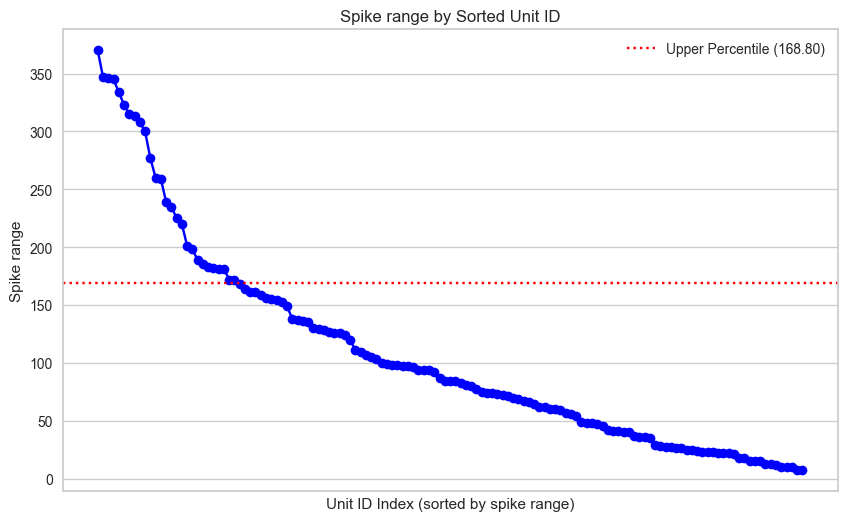

In [ ]:
plot_by_measure("static_gratings", "VISam", "range", 95)

This time, we increased our percentile to 95, as it already captures a nice subset of neurons.

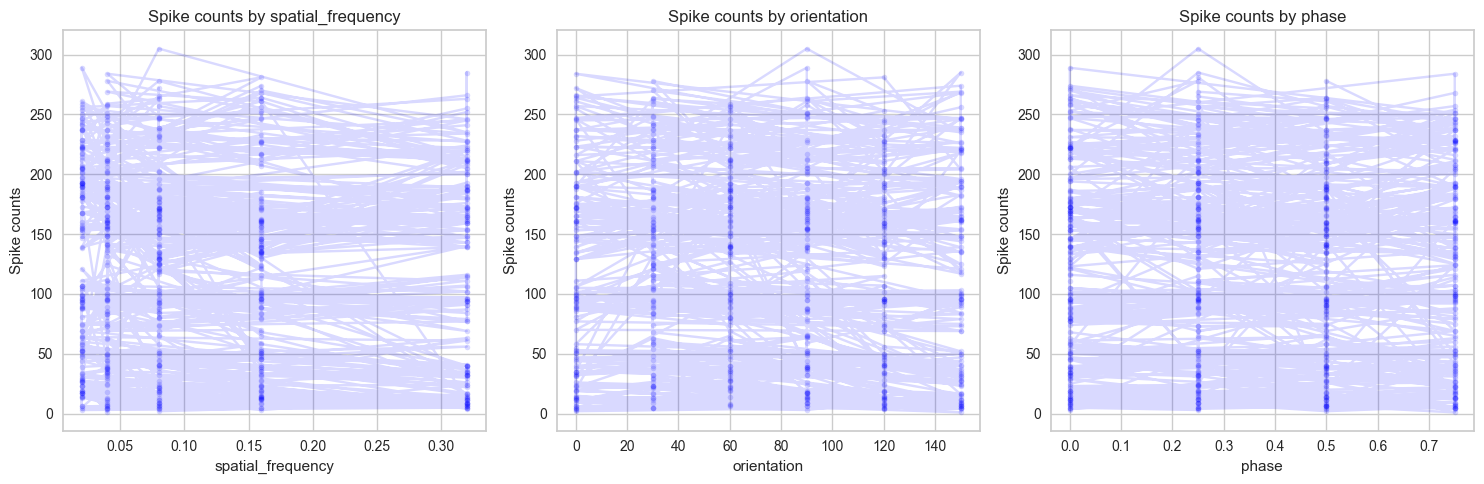

In [ ]:
spike_count_by_param("static_gratings", "VISam", ['spatial_frequency', 'orientation', 'phase'], "range", 95)

Once again, these plots give little or no intuition at all on the trends.

Let us compare the top neurons by variance with the top neurons by range, to check whether we can find some interesting cases.

In [ ]:
highest_variance[:10]

,unit_id,stimulus_condition_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,temporal_frequency,opacity,x_position,...,mask,stimulus_name,size,spatial_frequency,color,frame,orientation,y_position,phase,color_triplet
6,951092437,4787,155,47,3.297872,3.393824,0.495040,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
17,951092798,4787,52,47,1.106383,1.127406,0.164449,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
21,951092940,4787,282,47,6.000000,2.934058,0.427976,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
22,951092949,4787,297,47,6.319149,1.842805,0.268801,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
24,951092973,4787,270,47,5.744681,2.480078,0.361757,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
30,951093080,4787,390,47,8.297872,3.994098,0.582599,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
32,951093125,4787,58,47,1.234043,1.067561,0.155720,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
35,951093283,4787,267,47,5.680851,2.743422,0.400169,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
47,951093608,4787,281,47,5.978723,3.886931,0.566967,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"
60,951093928,4787,35,47,0.744681,1.241809,0.181137,null,True,null,...,None,static_gratings,"[250.0, 250.0]",0.02,null,null,150.0,null,0.5,"[1.0, 1.0, 1.0]"


In [ ]:
sort_by_range("static_gratings", "VISam")[1][:10]

[951092050,
 951092075,
 951092303,
 951092369,
 951092398,
 951092410,
 951092437,
 951092450,
 951092475,
 951092488]

We found out that among those neurons whose spiking activity has the highest variance there is also a neuron whose spiking activity has a very wide range. Therefore, it will be interesting to further analyse this particular cell (number $951092437$).

Let us take the dataset relative to this dataset's activity through trials.

In [ ]:
interesting_static_grating = unit_presentation_stimulus('static_gratings', np.array([951092437]))
interesting_static_grating

,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,opacity,contrast,units,mask,stimulus_name,size,spatial_frequency,orientation,phase,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
4787,155,47,3.297872,3.393824,0.495040,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.02,150.0,0.5,"[1.0, 1.0, 1.0]"
4788,250,50,5.000000,4.725096,0.668229,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.16,0.0,0.5,"[1.0, 1.0, 1.0]"
4789,311,48,6.479167,4.722015,0.681564,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.04,30.0,0.25,"[1.0, 1.0, 1.0]"
4790,174,48,3.625000,3.976661,0.573982,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.04,60.0,0.75,"[1.0, 1.0, 1.0]"
4791,174,47,3.702128,3.922704,0.572185,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.08,60.0,0.0,"[1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,142,50,2.840000,3.570628,0.504963,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.32,150.0,0.25,"[1.0, 1.0, 1.0]"
4904,84,47,1.787234,2.440030,0.355915,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.04,90.0,0.5,"[1.0, 1.0, 1.0]"
4905,233,49,4.755102,3.987118,0.569588,True,0.8,deg,None,static_gratings,"[250.0, 250.0]",0.16,0.0,0.0,"[1.0, 1.0, 1.0]"


Let us look at how its spikes change with respect to the three image properties of interest.

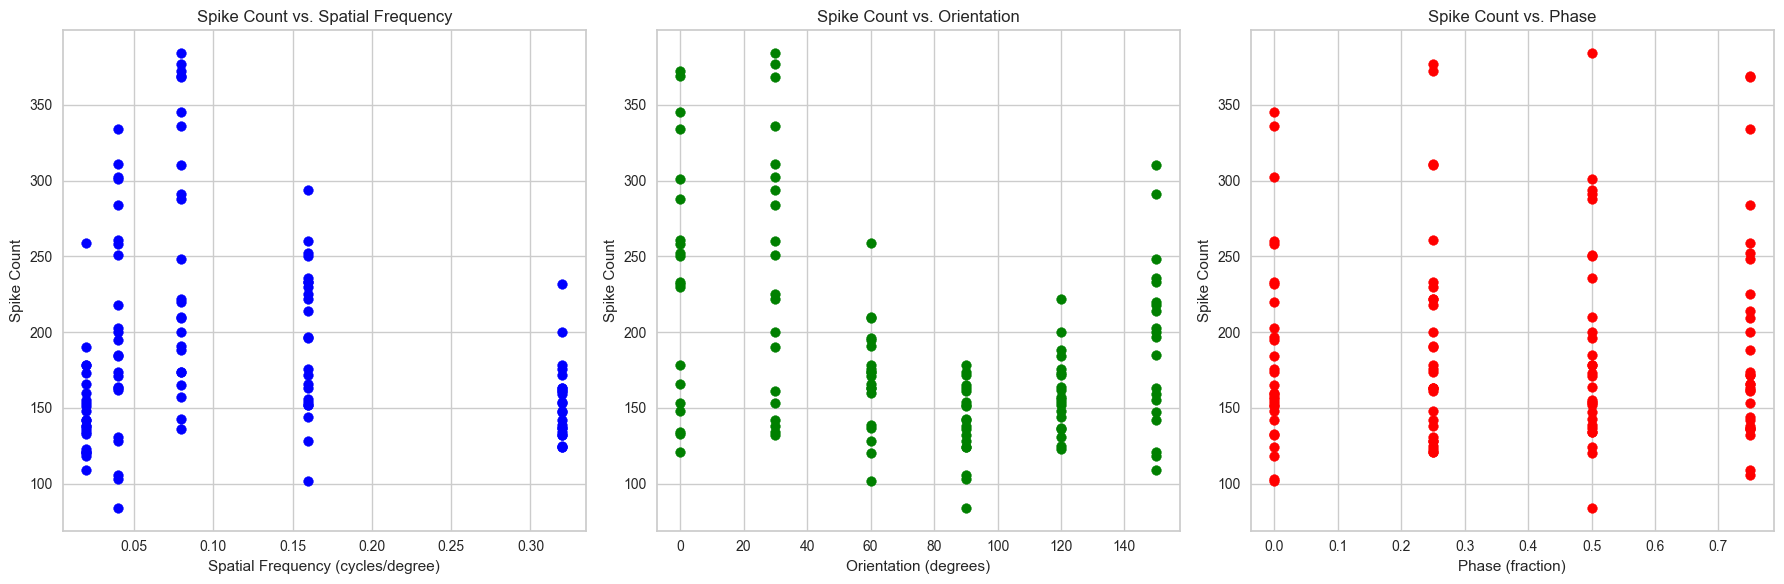

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


axs[0].scatter(interesting_static_grating['spatial_frequency'], interesting_static_grating['spike_count'], color='blue')
axs[0].set_title('Spike Count vs. Spatial Frequency')
axs[0].set_xlabel('Spatial Frequency (cycles/degree)')
axs[0].set_ylabel('Spike Count')
axs[0].grid(True)

axs[1].scatter(interesting_static_grating['orientation'], interesting_static_grating['spike_count'], color='green')
axs[1].set_title('Spike Count vs. Orientation')
axs[1].set_xlabel('Orientation (degrees)')
axs[1].set_ylabel('Spike Count')
axs[1].grid(True)

interesting_static_grating['phase'] = interesting_static_grating['phase'].astype(float)

axs[2].scatter(interesting_static_grating['phase'], interesting_static_grating['spike_count'], color='red')
axs[2].set_title('Spike Count vs. Phase')
axs[2].set_xlabel('Phase (fraction)')
axs[2].set_ylabel('Spike Count')
axs[2].grid(True)

plt.tight_layout()
plt.show()

Orientation and Spatial Frequency seem to affect the spiking activity of this neuron. Phase, on the other hand, doesn't look like a great factor in the variation of spiking activity.

### Modulation

Our attempt to collect those neurons whose activities depend the most on the image properties is by looking at the modulation of each unit. In particular, we say that the response of a unit is modulated by a variable if we can find a statistically significant difference in the values of the spike count as the variable changes.
There are various ways in which we could tackle this aspect. The approach we will follow is pretty straightforward and simple, and it could be improved upon.

For each unit, we take the best horizontal line fitting the data (that is given by the mean of the spike count) and we computed the average MSE. We expect that if the error is small, then the data is well fitted by an horizontal line, thus there is no modularity. Instead, if the error is large, then we can expect to observe some sort of modularity.

We then take the neurons with the highest error.

In [ ]:
check_modulation_line_useless("static_gratings", 'VISam')[:10]

[951098242,
 951093928,
 951094081,
 951093125,
 951092798,
 951099306,
 951097547,
 951093283,
 951092437,
 951092973]

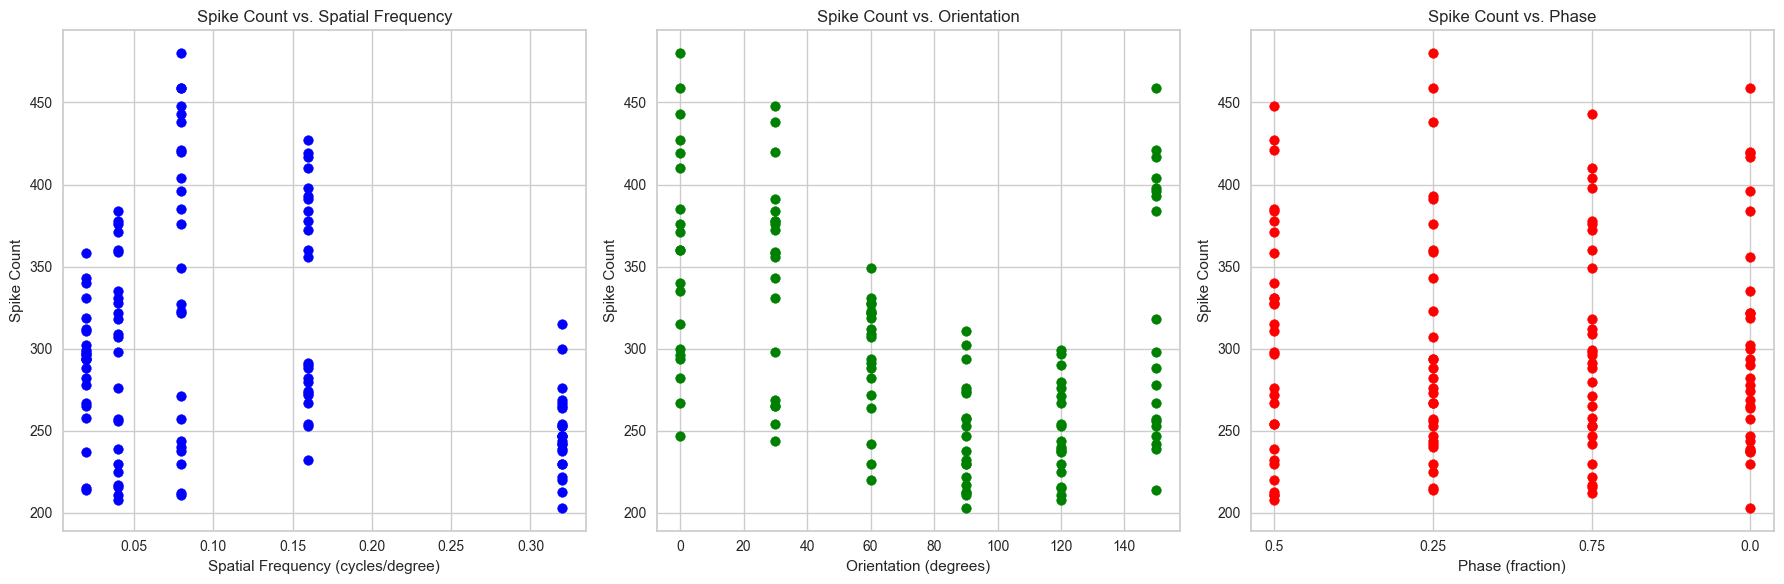

In [ ]:
interesting_static_grating = unit_presentation_stimulus('static_gratings', np.array([951093283]))
interesting_static_grating

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axs[0].scatter(interesting_static_grating['spatial_frequency'], interesting_static_grating['spike_count'], color='blue')
axs[0].set_title('Spike Count vs. Spatial Frequency')
axs[0].set_xlabel('Spatial Frequency (cycles/degree)')
axs[0].set_ylabel('Spike Count')
axs[0].grid(True)

axs[1].scatter(interesting_static_grating['orientation'], interesting_static_grating['spike_count'], color='green')
axs[1].set_title('Spike Count vs. Orientation')
axs[1].set_xlabel('Orientation (degrees)')
axs[1].set_ylabel('Spike Count')
axs[1].grid(True)

axs[2].scatter(interesting_static_grating['phase'], interesting_static_grating['spike_count'], color='red')
axs[2].set_title('Spike Count vs. Phase')
axs[2].set_xlabel('Phase (fraction)')
axs[2].set_ylabel('Spike Count')
axs[2].grid(True)

plt.tight_layout()
plt.show()

By looking at the plot, there seems to be some sort of modulation, that is a change in the reponse.

In [ ]:
check_modulation_line_useless("static_gratings", 'VISam')[-1]

If we take, instead, a unit with a low error we observe that the response of the neuron is not very interesting.

### Clustering

Next, we proceed working on an ambitious task. We will perform clustering on our dataset, aiming to find groups of images (still parametrized by *phase*, *orientation*, and *spacial frequency*), that produce a similar response in neurons.

The way in which we look for clusters, is using an unsupervised learning algorithm, called **k-means**. This algorithm partitions the data into *k* clusters by iteratively minimizing the sum of squared distances between data points and their assigned cluster centroids. To find the optimal value of *k*, the **elbow method** is commonly used. The elbow in the curve represents the point where increasing the number of clusters does not significantly improve the compactness of the clustering.

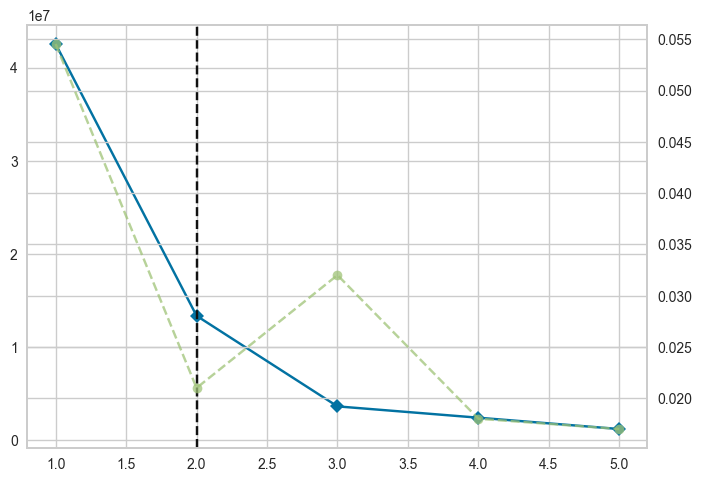

In [ ]:
k = k_elbow('static_gratings', 'VISam')


Using this method, we observe that the optimal amount of clusters to keep thoughout this section is $2$.

We now visualize the clusters in 2 and 3 dimensions. Since we are looking at three features, we use PCA to plot in 2D.

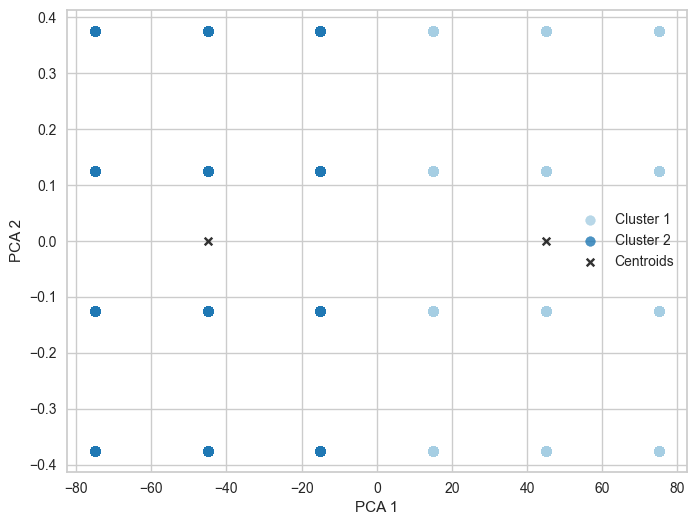

In [ ]:
k_means_visualizer('static_gratings', 'VISam', 2, k)

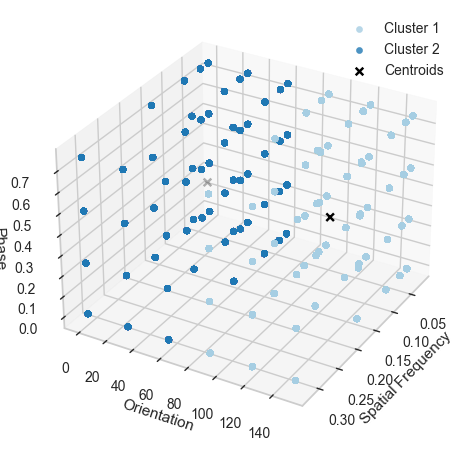

In [ ]:
k_means_visualizer('static_gratings', 'VISam', 3, k)

We notice that due to the discrete nature of the values that were used to create the dataset, there is no clear division between the clusters. This means that the used pictures are *all* similar to each other, and that there aren't specific groups of similarity.
Again, due to the fact that images have limited and discrete values, adding *mean spike rate* and *std spike rate* to the features doesn't change the results.
We conclude that analysis is inconclusive about the presence of images that might cause similar spiking in neurons.

## Main results

Overall, from a preliminary analysis of the data, we can already see some common trends in the neural activity. For example, by plotting all possible combinations of phase and orientation, we see that the neural response as a function of the frequency seems to have high values for small frequencies and then tends to decrease with the increase in frequency. Furthermore, by fixing different values of frequency and phase, the average spike per unit as a function of the orientation seems to decrease for median values of orientation (50 to 100 degrees) and tends to increase for flat angles (0 and 180 degrees).

This notebook was designed in a way such that the analysis could be trivially expanded to other areas of the brain and to other stimuli. Indeed, most functions can be called on different brain regions and stimuli based on the arguments they are given.